<a href="https://colab.research.google.com/github/HenryVRosas/hojas_chocloCNN/blob/main/hojas_choclo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de hojas de Choclo/Maiz

In [1]:
#Verifico la capacidad de GPU
!nvidia-smi

Tue Jul  2 20:21:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy
import os
from torch.utils.data import DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticación y creación del cliente de PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# ID del archivo compartido en Google Drive
file_id = '1qPXaqoRxj2IcomZQMXjuF4qcJV7ZAh6V'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archivo.zip')  # Nombre con el que se guardará el archivo en Colab

# Ruta de destino para descomprimir en Google Drive
extract_path = '/content/drive/My Drive/extracted'  # Especifica una ruta en tu Google Drive

# Crear el directorio de destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Descomprimir el archivo .zip
with zipfile.ZipFile('archivo.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Descompresión completa")

Descompresión completa


In [5]:
#Listo las carpetas que contiene el dataset
!ls '/content/drive/My Drive/extracted/dataset_choclo'

test  train  val


In [6]:
import random

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [92]:
# Cargar las imagenes - dataset

train_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/extracted/dataset_choclo/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(192),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])  # De imagenet

                                                ]))
val_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/extracted/dataset_choclo/val',
                                                  transform=transforms.Compose([
                                                  transforms.RandomRotation(10),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.Resize(210),
                                                  transforms.CenterCrop(192),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])

                                                ]))

test_dataset = torchvision.datasets.ImageFolder('/content/drive/My Drive/extracted/dataset_choclo/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(210),
                                                    transforms.CenterCrop(192),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])

                                                ]))

print(train_dataset)
print(val_dataset)
print(test_dataset)


Dataset ImageFolder
    Number of datapoints: 2936
    Root location: /content/drive/My Drive/extracted/dataset_choclo/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(192, 192), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 626
    Root location: /content/drive/My Drive/extracted/dataset_choclo/val
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=210, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(192, 192))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Numbe

In [93]:
# Loaders

batch_size_train = 64
batch_size_test = 64
batch_size_val = 64
learning_rate = 0.0009
num_epocas = 25
step_log = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size = batch_size_train,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size_test,
                                         shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size = batch_size_val,
                                         shuffle=True)

class_names = train_dataset.classes

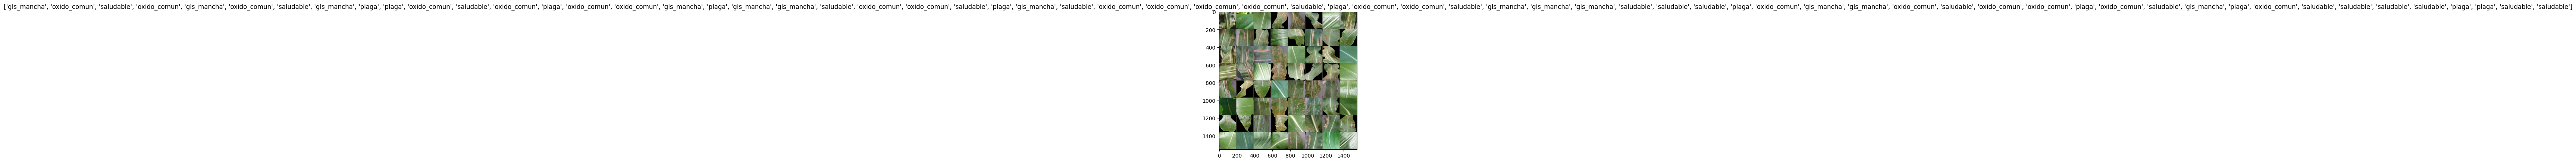

In [94]:
# Visualizar las imagenes

def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [95]:
# USAr GPU - CUDA

torch.cuda.set_device(0)
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


In [96]:
# Arquitectura de la red

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Ajustar el número de entradas al tamaño final del feature map
        self.fc1 = nn.Linear(128 * 24 * 24, 512)  # Cambiado de 28x28 a 24x24
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


network = Network()



In [97]:
# Mover a GPU
network = network.to(device)

In [98]:
#Modelo
def train_model(model, criterion, optimizer, scheduler, num_epochs, patience=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    no_improve_epoch = 0  # Contador de épocas sin mejor

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 25)

        #Train model


        #Tells your model that you are training the model
        model.train()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)


            #In PyTorch, we need to set the gradients to zero before starting to do backpropragation
            #because PyTorch accumulates the gradients on subsequent backward passes.
            optimizer.zero_grad()

            outputs = model(inputs)


            #Si utilizo softmax, puedo usar exp
            #We are doing it here just to make our predictions look like probabilities
            #which sometimes helps in debugging. You are free to remove torch.exp
            #call in the code if you want. torch.max returns a tuple containing the maximum value
            #and the index of the maximum value within the tensor. Since the index in our case
            #represents the classified category itself, we will only take that ignoring
            #the actual probability.
            #_, preds = torch.max(torch.exp(outputs), 1)

            #pytorch.max
            #Returns the maximum value of all elements in the input tensor.
            _, preds = torch.max(outputs, 1)

            #you should use labels, because u need to get loss by comparing ground truth
            #and predicting label, the predict is outputs, and the ground truth is labels
            loss = criterion(outputs, labels)

            #loss.backward() computes dloss/dx for every parameter x which has
            #requires_grad=True. These are accumulated into x.grad for every parameter x
            loss.backward()

            #optimizer.step updates the value of x using the gradient x.grad
            optimizer.step()

            #During an epoch, we need to update the LR using the ‘.step()’ method of the scheduler object
            scheduler.step()

            #the loss returned is an average over all examples in a batch, given this,
            #you could simply divide the running loss by the number of batches,
            #however since the final batch is often not the same size with others,
            #your results would be inaccurate, hence, the solution is to reverse the average
            #by multiplying the loss in a batch by the total number of images in the batch,
            #this gives unaveraged sum of losses over all examples, when you divide the running loss
            #by the total number of images ,you get accurate loss metrics.
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss /len(train_dataset)
        epoch_acc_train = running_corrects.double() / len(train_dataset)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))
        if epoch_acc_train > best_acc_train:
              best_acc_train = epoch_acc_train


        #Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #Context-manager that sets gradient calculation to on or off
            #Disabling gradient calculation is useful for inference, when you are sure that you will
            #not call Tensor.backward(). It will reduce memory consumption for computations that would
            #otherwise have requires_grad=True.
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)


                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss_val = running_loss /len(val_dataset)
        epoch_acc_val = running_corrects.double() / len(val_dataset)

        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))

        if epoch_loss_val < best_loss:
            no_improve_epoch = 0
            best_loss = epoch_loss_val
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            no_improve_epoch += 1

        if no_improve_epoch >= patience:
            print('Early stopping')
            break

        # Aquí agregas las líneas para guardar las métricas
        train_losses.append(epoch_loss_train)
        val_losses.append(epoch_loss_val)
        train_accuracies.append(epoch_acc_train.item())
        val_accuracies.append(epoch_acc_val.item())

        if epoch_acc_val > best_acc:
              best_acc = epoch_acc_val
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(best_model_wts, 'resnetxt.pth')

    time_elapsed = time.time() - since
    print("####################################################")
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best train accucary: {:.4f}'.format(best_acc_train))
    print('Best val accucary: {:.4f}'.format(best_acc))

        # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    model.load_state_dict(best_model_wts)

    return model

In [99]:
# Usar TEST

def test_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    return test_model

In [100]:
def visualize_model(model, num_images):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode = was_training)

Epoch 0/24
-------------------------
Train Loss: 0.6934 Acc: 0.7299
Val Loss: 0.5121 Acc: 0.8035
Epoch 1/24
-------------------------
Train Loss: 0.6463 Acc: 0.7524
Val Loss: 0.4936 Acc: 0.7987
Epoch 2/24
-------------------------
Train Loss: 0.6670 Acc: 0.7391
Val Loss: 0.4935 Acc: 0.7843
Epoch 3/24
-------------------------
Train Loss: 0.6547 Acc: 0.7486
Val Loss: 0.4909 Acc: 0.7859
Epoch 4/24
-------------------------
Train Loss: 0.6340 Acc: 0.7507
Val Loss: 0.4947 Acc: 0.7907
Epoch 5/24
-------------------------
Train Loss: 0.6520 Acc: 0.7439
Val Loss: 0.4856 Acc: 0.8115
Epoch 6/24
-------------------------
Train Loss: 0.6557 Acc: 0.7343
Val Loss: 0.5063 Acc: 0.7987
Epoch 7/24
-------------------------
Train Loss: 0.6636 Acc: 0.7446
Val Loss: 0.4949 Acc: 0.7891
Epoch 8/24
-------------------------
Train Loss: 0.6422 Acc: 0.7418
Val Loss: 0.4907 Acc: 0.7923
Epoch 9/24
-------------------------
Train Loss: 0.6442 Acc: 0.7418
Val Loss: 0.4936 Acc: 0.7987
Epoch 10/24
------------------

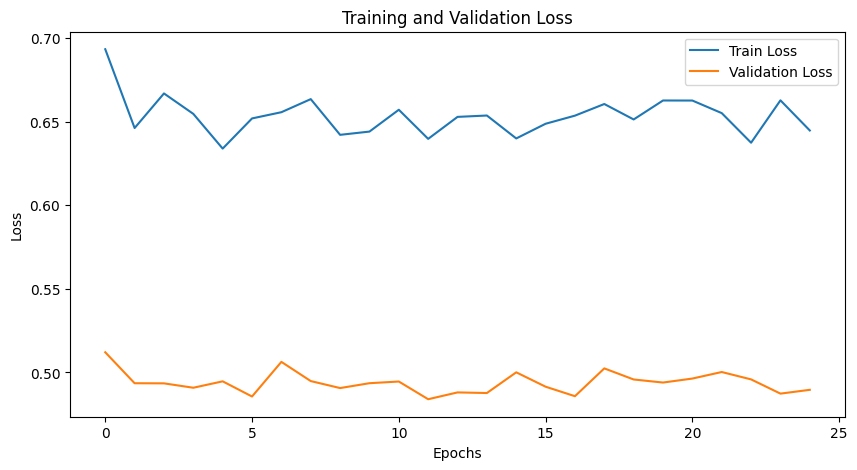

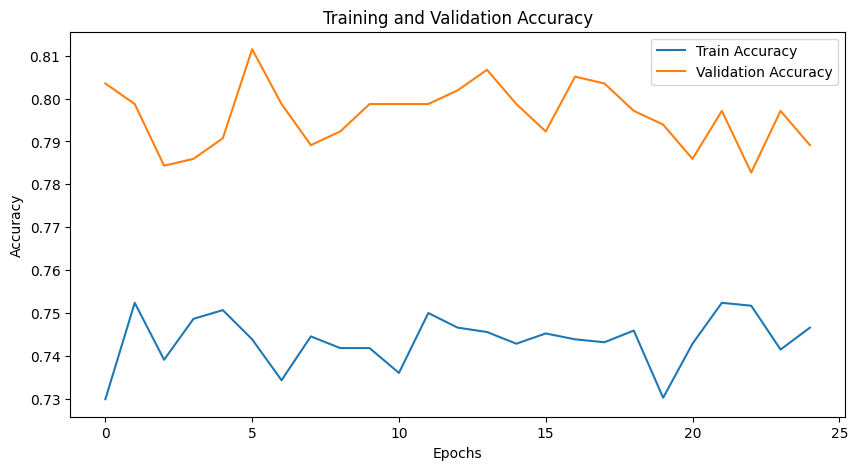

In [101]:
# Entrenamiento EPIENetv1.0
# criterion y epocas iguales
# guardar el mejor modelo
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_propio = train_model(network, criterion, optimizer, scheduler,  num_epochs=25)

In [102]:
# Probar con test
model_propio_test = test_model(model_propio)

Test Loss: 0.4582 Acc: 0.8115


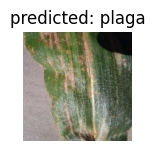

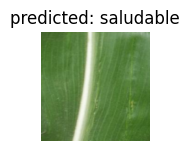

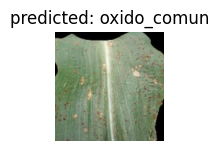

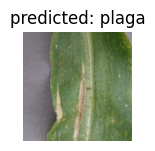

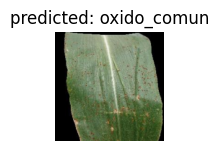

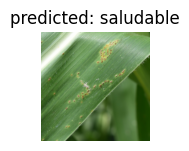

In [103]:
visualize_model(model=model_propio, num_images=6)
